이 코드는 MySQL DB에서 카테고리별로 특정 시간 기간(일별, 주별, 월별) 동안의 공지사항 수를 쿼리하고 가중치를 계산합니다. <br>
그런 다음 그 가중치를 사용하여 각 카테고리의 요청 횟수를 계산하고 시각화합니다. <br>
<br>
코드에 대한 설명
- get_percentile: 주어진 값(value)과 최소값(min_value) 및 최대값(max_value)을 사용하여 백분위 값을 계산합니다. <br>
- frequencyUpdate: MySQL DB에 연결하여 시간 기간별 공지사항 수를 쿼리하고 커서를 사용하여 결과를 가져옵니다. 그런 다음 각 시간 기간별로 최대/최소 공지사항 카운트를 계산하고 백분위 값을 구한 다음 가중치를 계산합니다. <br>

<br>
본 코드에서는 특정 한 날짜의 가중치를 계산한 후, 시간이 지남에 따라 가중치 변화를 분석합니다. <br>
시각화 부분에서는 matplotlib.pyplot을 사용하여 각 카테고리별 가중치, 변화 추이 그래프를 생성하고, 마지막으로 요청 횟수의 변화를 그래프로 표현합니다.<br>
이 코드를 실행하면 결론적으로 요청 횟수에 변화가 있는지, 가중치 값의 변화에 대한 내용을 파악할 수 있습니다.

In [167]:
import MySQLdb
import datetime
import math
import random
import matplotlib.pyplot as plt
import numpy as np

# MySQL 연결 정보
host = 'localhost'
user = 'root'
passwd = '1234'
db = 'ossProject'


In [168]:
def get_percentile(value, min_value, max_value):
    percentile = (value - min_value) / (max_value - min_value) * 23 + 1
    return int(percentile)

In [169]:
def frequencyUpdate(current_date):
    try:
        connection = MySQLdb.connect(
            host=host,
            user=user,
            passwd=passwd,
            db=db
        )
        cursor = connection.cursor()

        # 일별 카운트 쿼리
        daily_query = f'''
        SELECT Category.Cid, IFNULL(COUNT(Notice.Cid_id), 0) AS day_count
        FROM category
        LEFT JOIN Notice ON Category.Cid = Notice.Cid_id AND DATE(Notice.time) = '{current_date}'
        GROUP BY Category.Cid
        '''
        cursor.execute(daily_query)
        daily_counts = cursor.fetchall()

        # 주별 카운트 쿼리
        start_of_week = current_date - datetime.timedelta(days=current_date.weekday())
        end_of_week = start_of_week + datetime.timedelta(days=6)
        weekly_query = f'''
        SELECT Category.Cid, IFNULL(COUNT(Notice.Cid_id), 0) AS week_count
        FROM category
        LEFT JOIN Notice ON Category.Cid = Notice.Cid_id AND DATE(Notice.time) >= '{start_of_week}' AND DATE(Notice.time) <= '{end_of_week}'
        GROUP BY Category.Cid
        '''
        cursor.execute(weekly_query)
        weekly_counts = cursor.fetchall()

        # 월별 카운트 쿼리
        start_of_month = current_date.replace(day=1)
        end_of_month = current_date.replace(day=28) + datetime.timedelta(days=4)
        monthly_query = f'''
        SELECT Category.Cid, IFNULL(COUNT(Notice.Cid_id), 0) AS month_count
        FROM category
        LEFT JOIN Notice ON Category.Cid = Notice.Cid_id AND DATE(Notice.time) >= '{start_of_month}' AND DATE(Notice.time) <= '{end_of_month}'
        GROUP BY Category.Cid
        '''
        cursor.execute(monthly_query)
        monthly_counts = cursor.fetchall()

        # 키워드 카운트 쿼리
        keyword_query = f'''
        SELECT Category.Cid, IFNULL(COUNT(keyword.Cid_id), 0) AS key_count
        FROM category
        LEFT JOIN keyword ON Category.Cid = keyword.Cid_id
        GROUP BY Category.Cid
        '''

        cursor.execute(keyword_query)
        keyword_counts = cursor.fetchall()

        # 일별 최대, 최소 카운트
        day_max = max(daily_counts, key=lambda x: x[1])
        day_min = min(daily_counts, key=lambda x: x[1])

        # 주별 최대, 최소 카운트
        week_max = max(weekly_counts, key=lambda x: x[1])
        week_min = min(weekly_counts, key=lambda x: x[1])

        # 월별 최대, 최소 카운트
        month_max = max(monthly_counts, key=lambda x: x[1])
        month_min = min(monthly_counts, key=lambda x: x[1])

        # 키워드별 최대, 최소 카운트
        keyword_max = max(keyword_counts, key=lambda x: x[1])
        keyword_min = min(keyword_counts, key=lambda x: x[1])

        #가중치를 시간으로 환산
        keyword_percentile = [get_percentile(count[1], keyword_min[1], keyword_max[1]) for count in keyword_counts]

        day_percentile = [get_percentile(count[1], day_min[1], day_max[1]) for count in daily_counts]

        week_percentile = [get_percentile(count[1], week_min[1], week_max[1]) for count in weekly_counts]

        month_percentile = [get_percentile(count[1], month_min[1], month_max[1]) for count in monthly_counts]


        # weight 계산
        weights = [(100 - (keyword_percentile[i] + day_percentile[i] + week_percentile[i] + month_percentile[i]))/4
                   for i in range(len(keyword_percentile))]
        
        print("최종 weight값")
        print(weights)

        # 커서와 연결 종료
        cursor.close()
        connection.close()

        return weights

    except Exception as e:
        pass


In [170]:
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2023, 2, 28)
delta = datetime.timedelta(days=1)

weights_list = []
old_req_counts = []
total_req_counts = []

while start_date <= end_date:
    weights = frequencyUpdate(start_date)

    if weights != None:
        # 각 카테고리에 대한 요청 횟수 계산 (하루 동안 주기적으로 처리되는 특정 작업의 횟수)
        weights_list.append(weights)
        req_counts = [math.ceil(24 / weight) for weight in weights]
        old_req_count = [math.ceil(24 / 1) for weight in weights]

        # 전체 요청수 합산
        total_req_counts.append(sum(req_counts))
        old_req_counts.append(sum(old_req_count))
    start_date += delta

최종 weight값
[2.625, 8.25, 4.0, 9.75, 8.625, 11.125, 9.5, 10.5, 9.875, 11.0, 10.25, 11.5, 12.0, 9.25, 10.125, 11.375, 10.5, 11.125, 11.5, 8.75, 9.875, 11.875, 10.375, 9.375, 11.125, 11.625, 9.0, 11.75, 11.625, 10.5, 11.875, 9.75, 12.0, 7.875, 9.25, 9.0, 10.125, 10.875, 10.875, 10.375, 11.625, 11.375, 10.375, 10.375, 10.875, 8.625, 9.375, 8.75, 11.375, 10.5, 10.375, 10.375, 9.125, 10.75, 11.625, 9.375, 11.75, 11.0, 10.0, 11.0, 9.5, 11.375, 11.375, 11.125, 9.5, 9.5, 10.125, 10.875, 10.25, 10.875, 10.375, 9.5, 11.75]
최종 weight값
[1.875, 7.625, 6.25, 9.75, 8.875, 11.125, 8.875, 10.75, 9.875, 11.0, 10.5, 11.5, 12.0, 9.25, 10.125, 11.375, 10.5, 11.375, 11.5, 9.0, 9.875, 11.875, 10.375, 9.375, 9.75, 11.625, 6.875, 11.75, 11.625, 10.5, 11.875, 9.75, 12.0, 7.125, 9.25, 9.0, 10.125, 10.875, 10.875, 10.375, 11.625, 10.75, 10.375, 10.625, 10.25, 9.25, 9.375, 9.0, 11.375, 10.5, 10.375, 10.375, 9.125, 10.75, 11.625, 9.625, 11.75, 10.625, 9.625, 11.0, 9.5, 11.375, 11.375, 11.125, 9.5, 9.5, 10.125, 10.87

In [171]:
import numpy as np
import pandas as pd
filtered_weights_list = [item for item in weights_list if item is not None]
transpose_filtered_weights = np.array(filtered_weights_list)

dates = [datetime.date(2022, 6, 1) + datetime.timedelta(days=i) for i in range(len(total_req_counts))]
col = ['일반공지', '학사공지', '장학공지', '입시공지', '국제공지', '학술/행사공지', '행사공지', '알림사항', '불교학부', '문화재학과', '문과대학', '국어국문문예창작학부', '영어영문학부', '일본학과', '중어중문학과', '철학과', '사학과', '이과대학', '수학과', '화학과', '통계학과', '물리반도체과학부', '법학과', '사회과학대학', '정치외교학전공', '행정학전공', '북한학전공', '경제학과', '국제통상학전공', '미디어커뮤니케이션학과', '식품산업관리학과', '사회학전공', '사회복지학과', '경찰사법대학', '경찰행정학부', '경영대학', '경영학과', '회계학과', '경영정보학과', '바이오시스템대학', '공과대학', '전자전기공학부', '정보통신공학과', '건설환경공학과', '화공생물공학과', '기계로봇에너지공학과', '건축공학과,건축학과', '산업시스템공학과', '융합에너지신소재공학과', 'AI융합대학', '컴퓨터공학과', '멀티미디어공학과', '사범대학', '교육학과', '국어교육과', '역사교육과', '지리교육과', '수학교육과', '가정교육과', '체육교육과', '예술대학', '미술학부', '연극학부', '한국음악과', '영화영상학과', '약학과', '다르마칼리지', '융합보안학과', '사회복지상담학과', '글로벌무역학과', '중앙도서관', '기숙사', '생협']
df = pd.DataFrame(transpose_filtered_weights, columns=col, index=dates)

df

,일반공지,학사공지,장학공지,입시공지,국제공지,학술/행사공지,행사공지,알림사항,불교학부,문화재학과,...,한국음악과,영화영상학과,약학과,다르마칼리지,융합보안학과,사회복지상담학과,글로벌무역학과,중앙도서관,기숙사,생협
2022-06-01,2.625,8.250,4.000,9.750,8.625,11.125,9.500,10.500,9.875,11.0,...,11.125,9.5,9.500,10.125,10.875,10.25,10.875,10.375,9.500,11.75
2022-06-02,1.875,7.625,6.250,9.750,8.875,11.125,8.875,10.750,9.875,11.0,...,11.125,9.5,9.500,10.125,10.875,10.25,10.875,10.375,9.750,11.75
2022-06-03,4.750,5.375,6.875,9.750,8.875,11.125,9.500,10.750,9.875,11.0,...,11.125,9.5,9.500,10.125,10.875,10.25,10.875,10.375,9.750,11.75
2022-06-04,2.875,7.500,4.625,8.750,6.250,11.125,9.625,11.000,7.750,11.0,...,11.125,9.5,9.000,10.125,10.875,10.25,10.875,10.375,9.500,11.75
2022-06-05,1.875,5.500,4.625,9.625,6.750,11.125,9.625,11.000,5.750,11.0,...,11.125,9.5,7.625,10.125,10.875,10.25,10.875,10.375,9.500,11.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10,4.250,5.000,6.625,9.750,8.500,11.125,8.375,4.875,9.000,11.0,...,11.125,9.5,6.250,10.125,10.875,10.25,10.875,10.250,10.250,11.75
2023-02-11,4.750,7.750,9.625,9.750,9.250,11.250,9.375,8.625,9.750,11.0,...,11.125,9.5,8.500,10.125,10.875,10.25,10.875,10.250,10.250,11.75
2023-02-12,4.750,5.500,9.625,9.750,9.250,11.250,9.375,5.750,9.750,11.0,...,11.125,9.5,8.000,10.125,10.875,10.25,10.875,10.250,10.250,11.75
2023-02-13,2.625,7.125,9.625,9.750,8.625,11.250,9.375,8.625,9.125,11.0,...,11.125,9.5,7.125,10.125,10.875,10.25,10.875,10.250,10.250,11.75


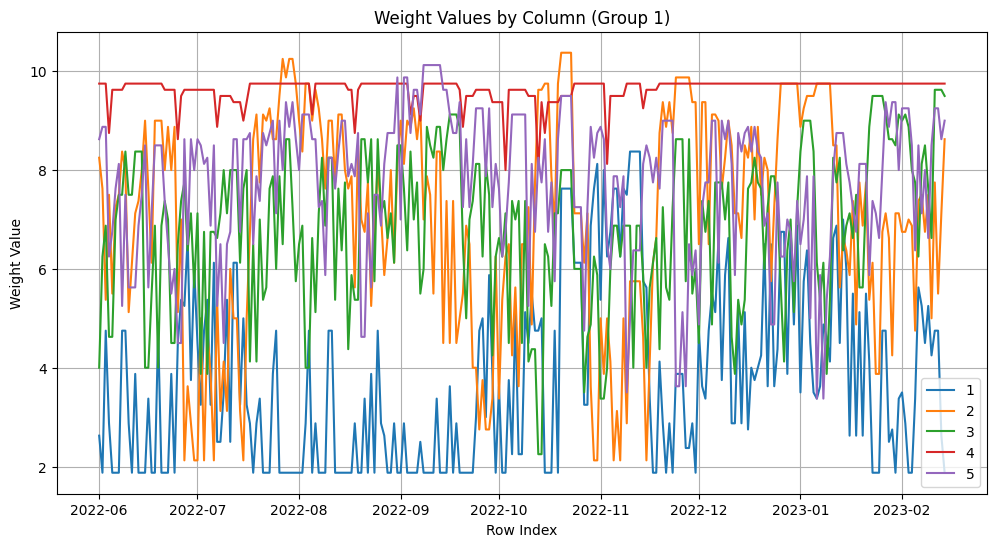

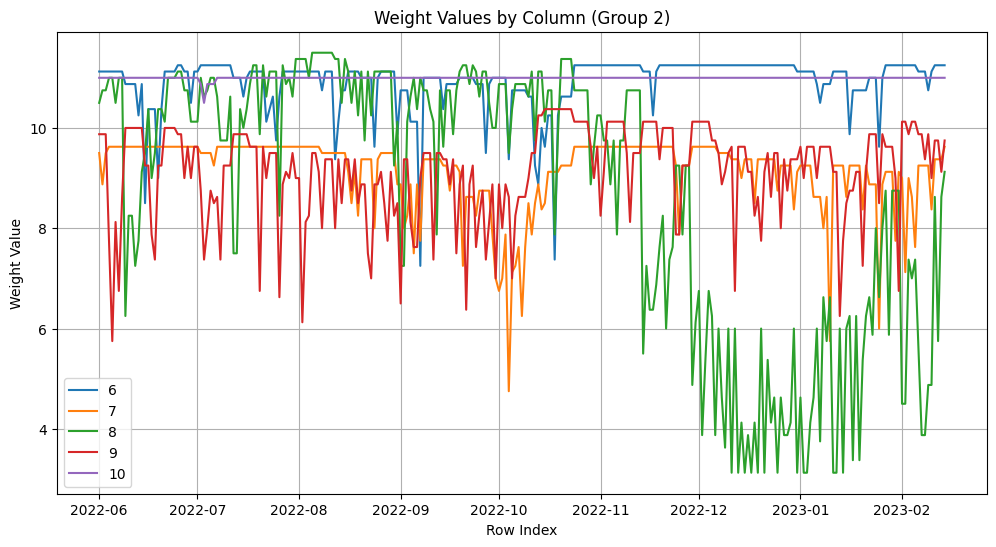

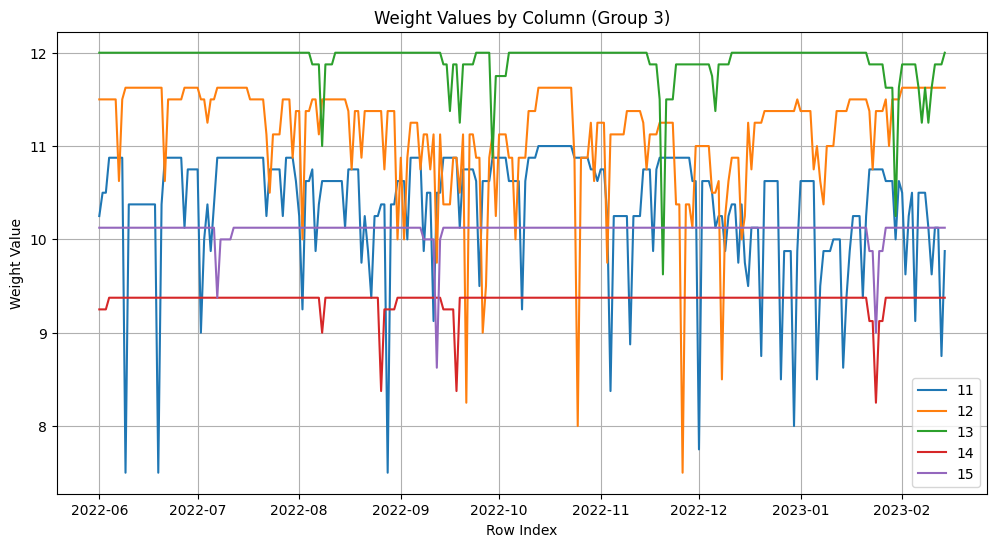

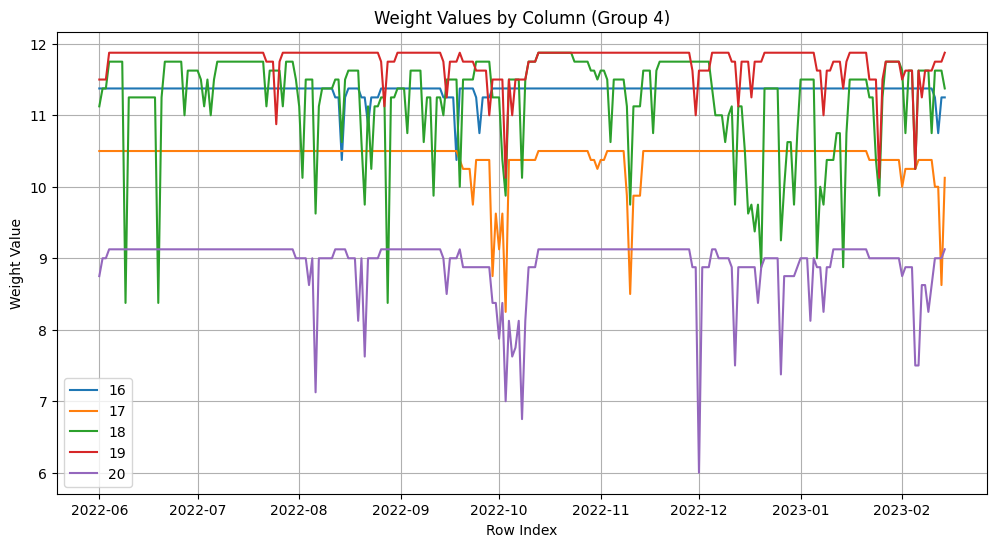

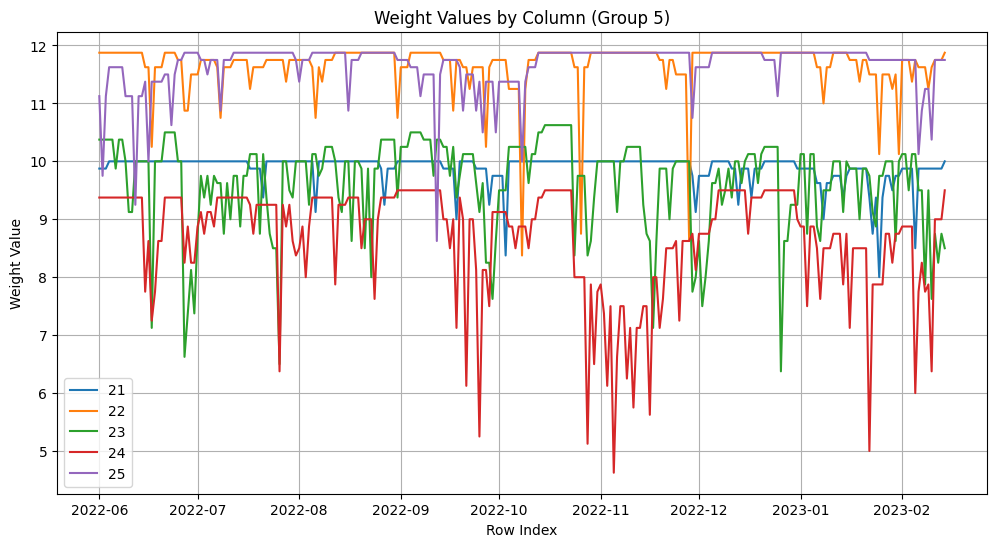

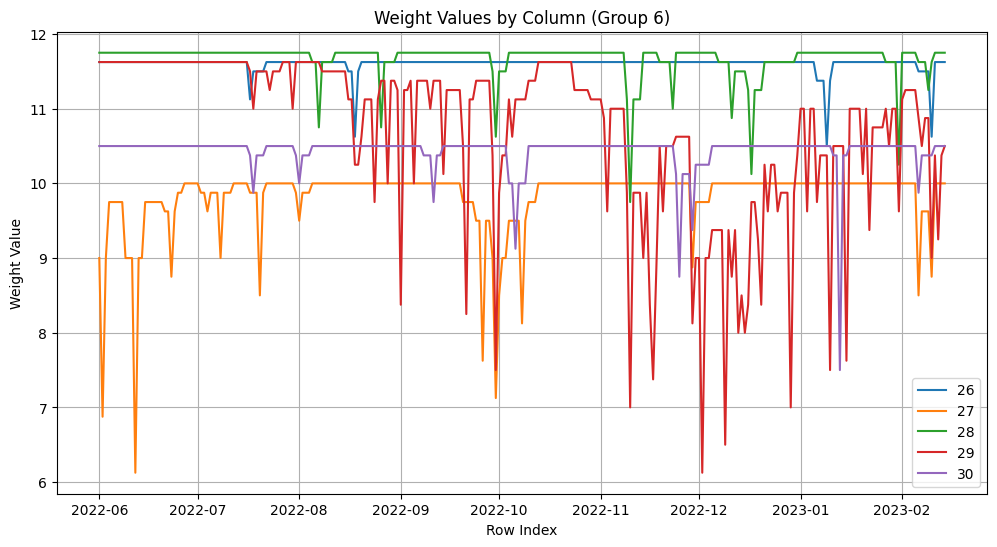

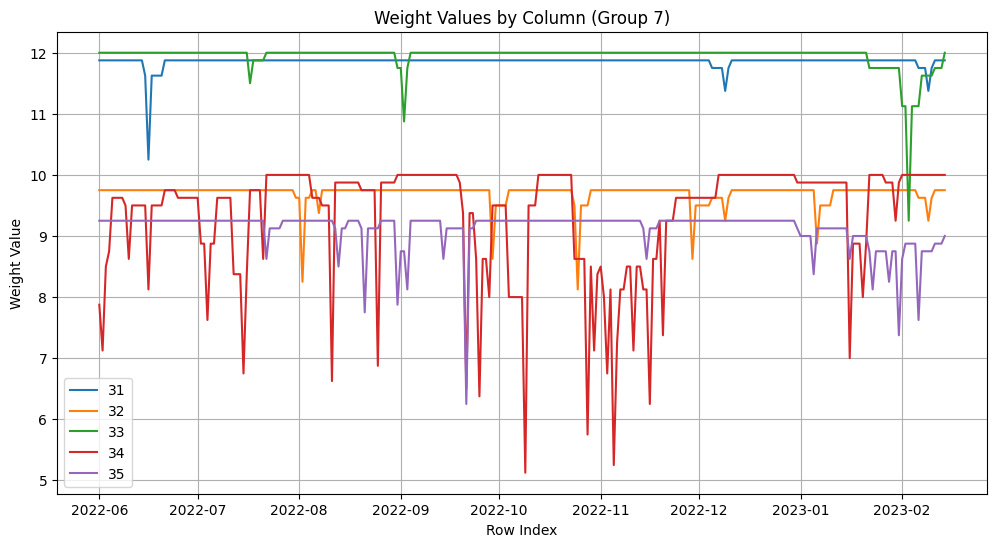

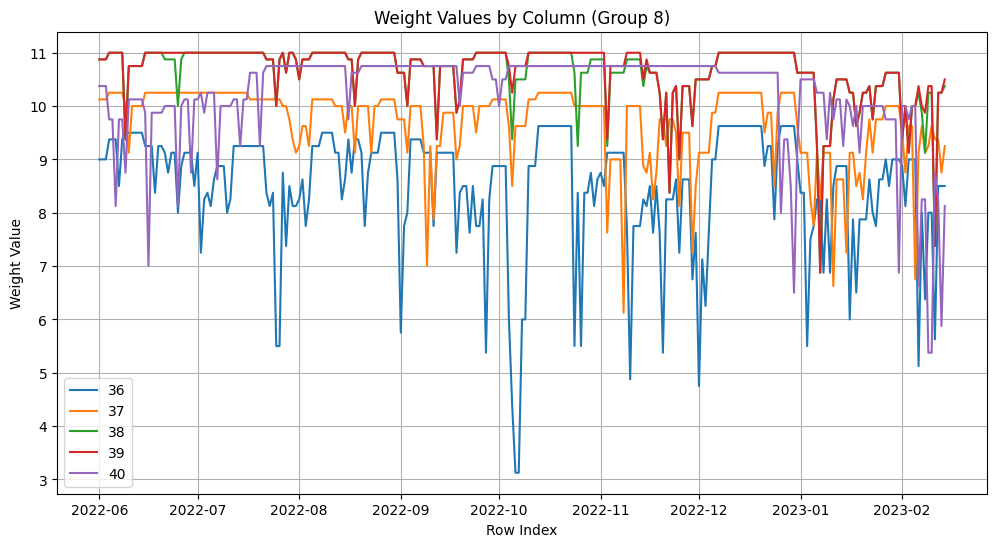

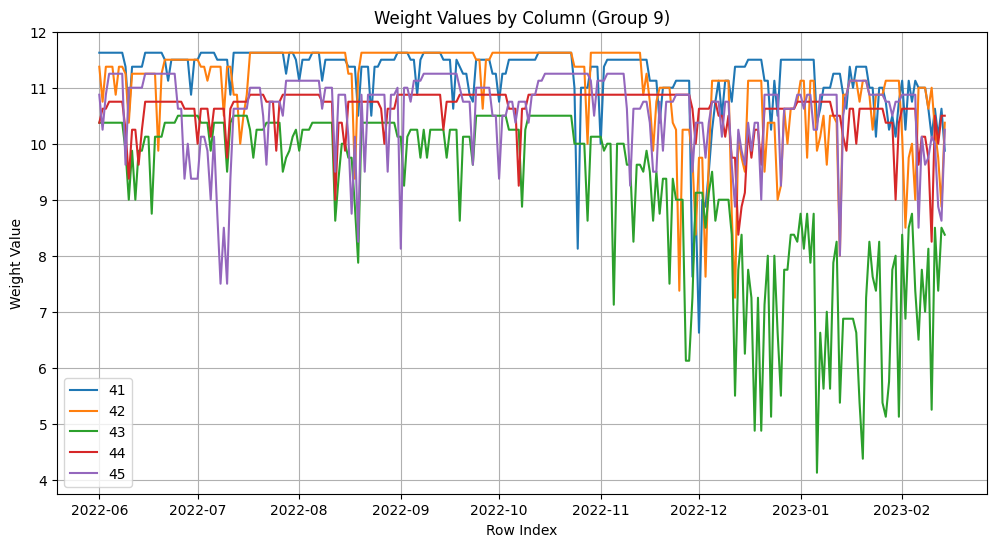

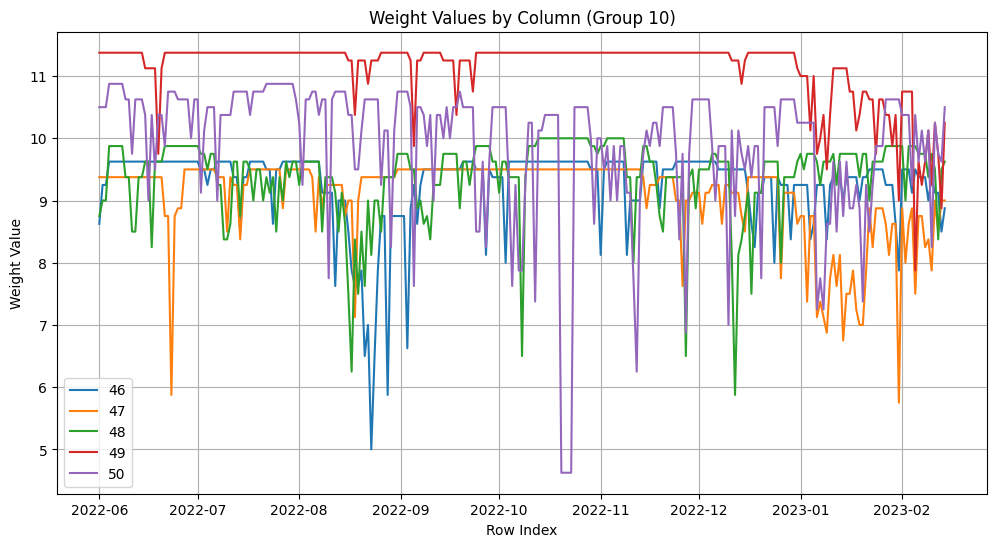

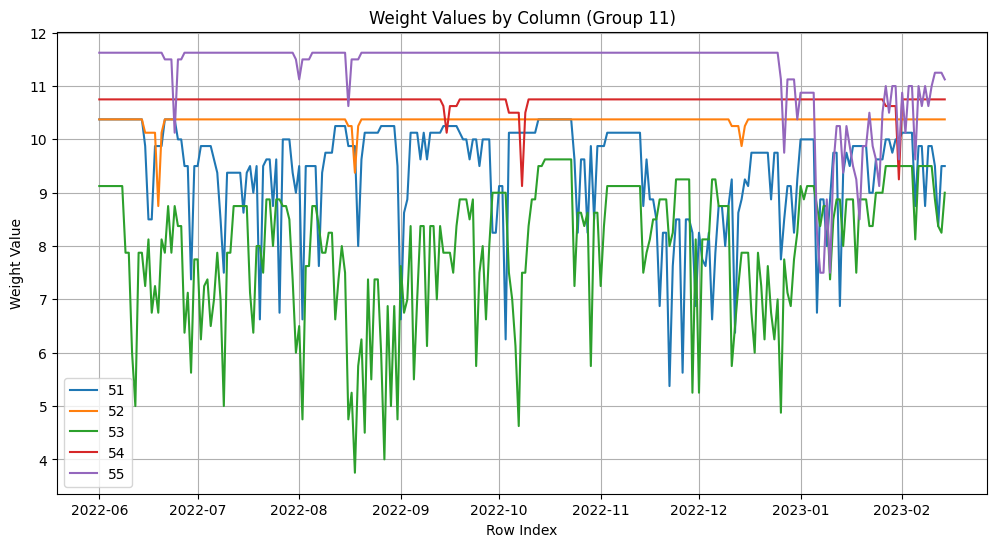

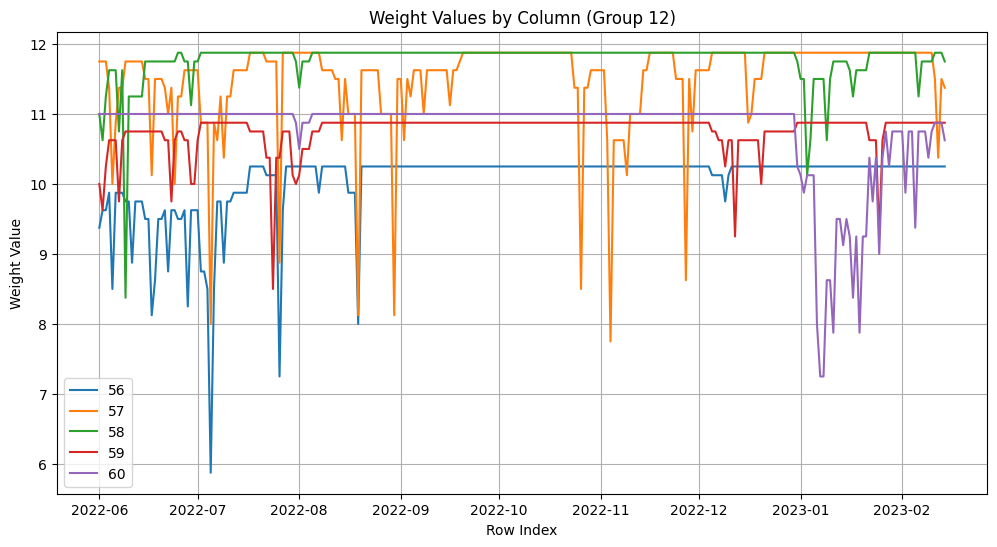

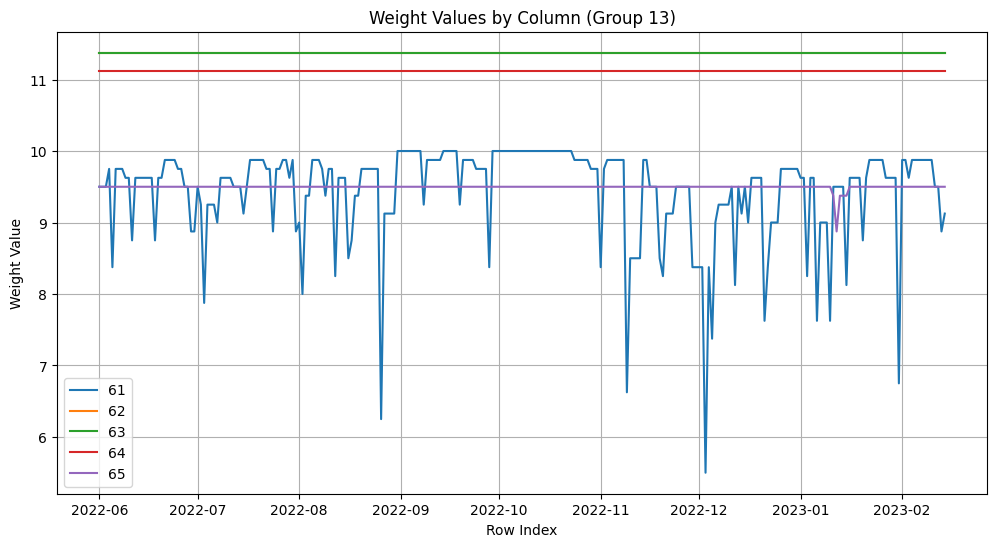

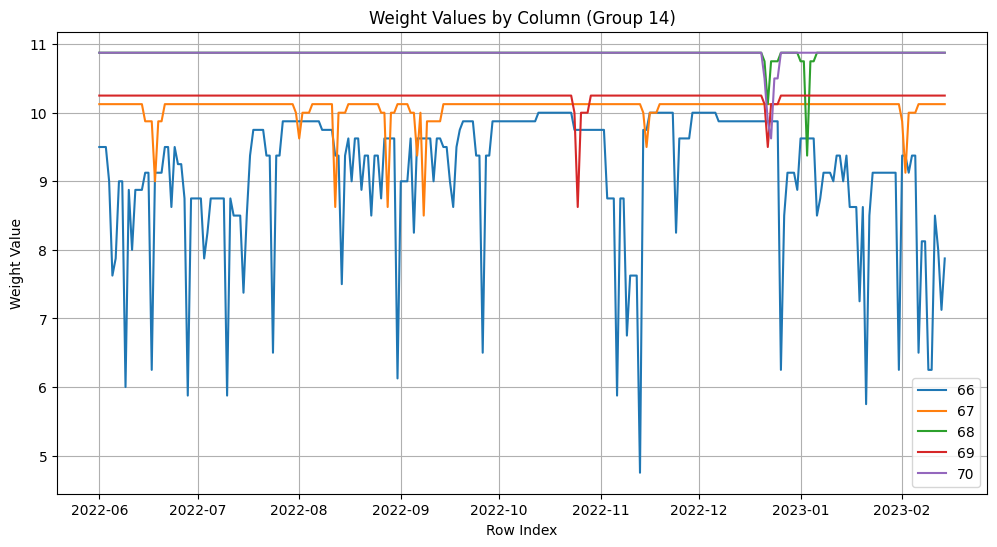

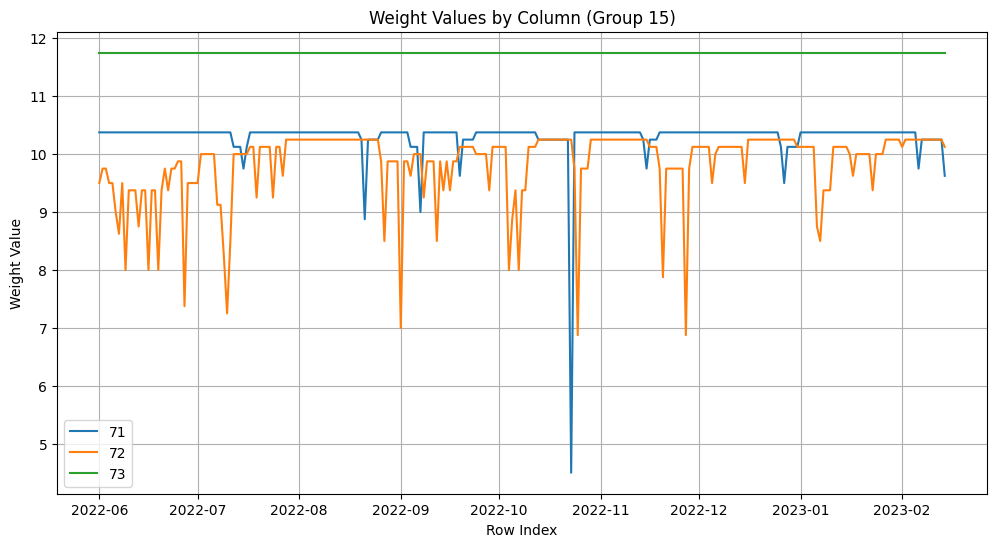

In [173]:
# 5개씩 컬럼을 자르고 시각화
n = 5
for i in range(0, len(df.columns), n):
    plt.figure(figsize=(12, 6))

    for j in range(i, min(i + n, len(df.columns))):
        column_name = df.columns[j]
        plt.plot(df[column_name], label=f'{j+1}')

    plt.xlabel('Row Index')
    plt.ylabel('Weight Value')
    plt.title(f'Weight Values by Column (Group {i // n + 1})')

    plt.legend(loc='best')
    plt.grid()
    plt.show()

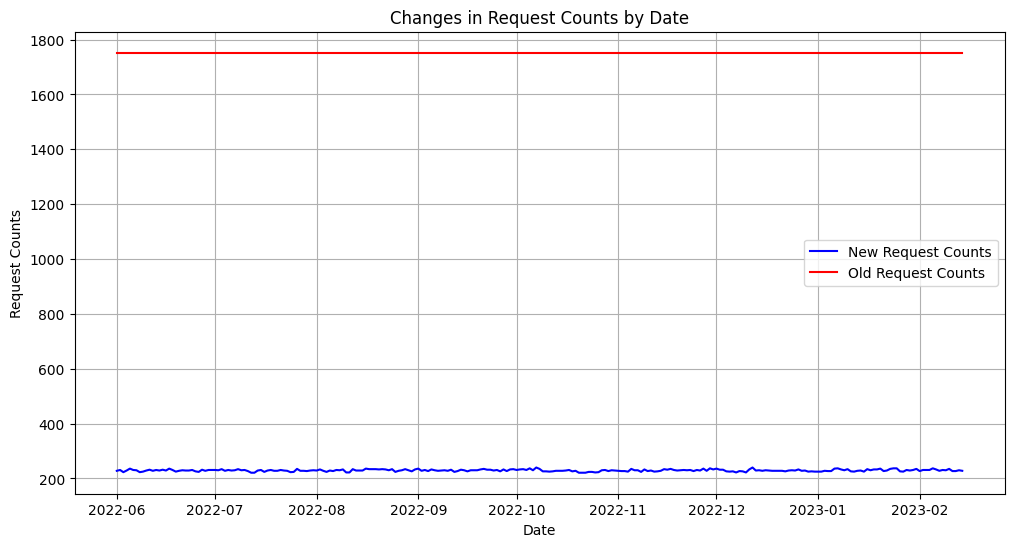

In [174]:
plt.figure(figsize=(12, 6))

plt.plot(dates, total_req_counts, label='New Request Counts', color='blue')
plt.plot(dates, old_req_counts, label='Old Request Counts', color='red')

plt.xlabel('Date')
plt.ylabel('Request Counts')
plt.title('Changes in Request Counts by Date')

plt.legend(loc='best')
plt.grid()
plt.show()

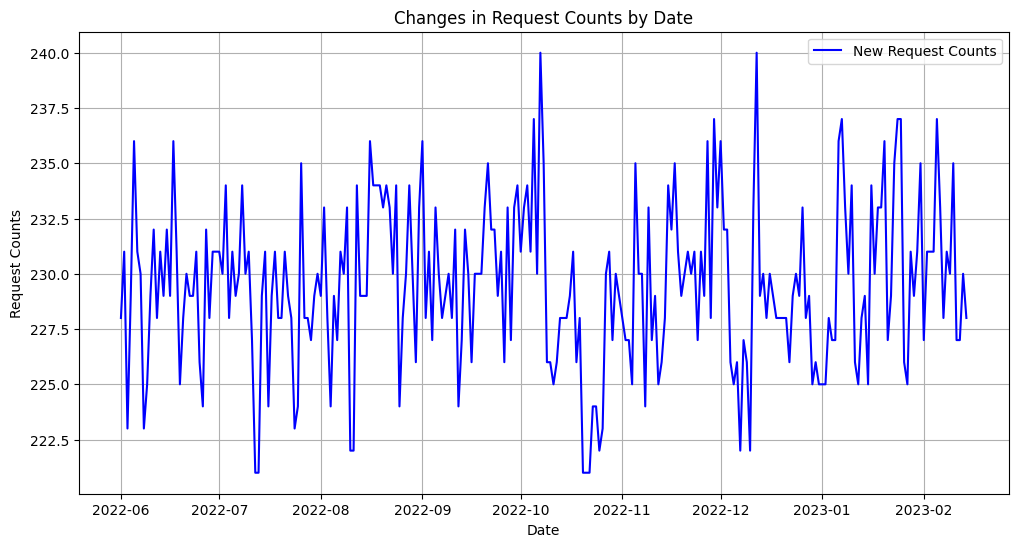

In [175]:
plt.figure(figsize=(12, 6))

plt.plot(dates, total_req_counts, label='New Request Counts', color='blue')

plt.xlabel('Date')
plt.ylabel('Request Counts')
plt.title('Changes in Request Counts by Date')

plt.legend(loc='best')
plt.grid()
plt.show()